In [32]:
from functools import partial
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [88]:
def gaussian_Q_half_kernel(
    landmarks: jnp.ndarray, alpha: float, sigma: float
) -> jnp.ndarray:
    xy_coords = landmarks.reshape(-1, 2)
    num_landmarks = xy_coords.shape[0]
    diff = xy_coords[:, jnp.newaxis, :] - xy_coords[jnp.newaxis, :, :]
    dis = jnp.sum(jnp.square(diff), axis=-1)
    kernel = alpha * jnp.exp(-0.5 * dis / (sigma**2)) 
    # kernel = (1 + jnp.sqrt(3) * dis / sigma) * jnp.exp(-jnp.sqrt(3) * dis / sigma)
    # Q_half = jnp.einsum("ij,kl->ikjl", kernel, jnp.eye(2))
    # Q_half = Q_half.reshape(2 * num_landmarks, 2 * num_landmarks)
    return kernel


def gaussian_Q_kernel(
    landmarks: jnp.ndarray, alpha: float, sigma: float
) -> jnp.ndarray:
    xy_coords = landmarks.reshape(-1, 2)
    num_landmarks = xy_coords.shape[0]
    diff = xy_coords[:, jnp.newaxis, :] - xy_coords[jnp.newaxis, :, :]
    dis = jnp.sum(jnp.square(diff), axis=-1)
    kernel = (
        (alpha**2)  * (2.0 * jnp.pi) * jnp.exp(-0.25 * dis / (sigma**2))
    )
    Q = jnp.einsum("ij,kl->ikjl", kernel, jnp.eye(2))
    Q = Q.reshape(2 * num_landmarks, 2 * num_landmarks)
    return Q

In [59]:
def gaussian_kernel_2d(x: jnp.ndarray, y: jnp.ndarray, alpha: float, sigma: float) -> jnp.ndarray:
    return alpha * jnp.exp(-jnp.linalg.norm(x - y, axis=-1) ** 2 / (2 * sigma ** 2))

def evaluate_Q(landmarks: jnp.ndarray, grid: jnp.ndarray, alpha: float, sigma: float) -> jnp.ndarray:
    Q = jax.vmap(
        jax.vmap(
            jax.vmap(
                partial(gaussian_kernel_2d, alpha=alpha, sigma=sigma),
                in_axes=(None, 0),
                out_axes=0
            ),
            in_axes=(None, 1),
            out_axes=1
        ),
        in_axes=(0, None),
        out_axes=0
    )(landmarks, grid)    # (n_bases, n_grid, n_grid)
    n_pts, n_grid, n_grid = Q.shape
    return Q.reshape(n_pts, n_grid * n_grid)

In [99]:
def circle(n_pts, key=jax.random.PRNGKey(0)):
    key1, key2 = jax.random.split(key)
    theta = jnp.linspace(0, 2.0 * jnp.pi, n_pts)
    x = jnp.cos(theta) + jax.random.normal(key1, (n_pts,)) * 0.5
    y = jnp.sin(theta) + jax.random.normal(key2, (n_pts,)) * 0.5
    return jnp.stack([x, y], axis=1)

In [100]:
grid_range = [-1.5, 1.5]
grid = jnp.linspace(grid_range[0], grid_range[1], 32)
grid = jnp.stack(jnp.meshgrid(grid, grid, indexing='xy'), axis=-1)

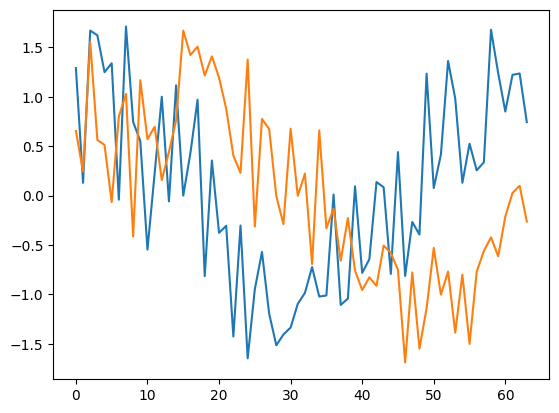

In [101]:
circle_landmarks = circle(64)
plt.plot(circle_landmarks[:, 0])
plt.plot(circle_landmarks[:, 1])

8.516723e-17
32
0.0
60
0.0
83


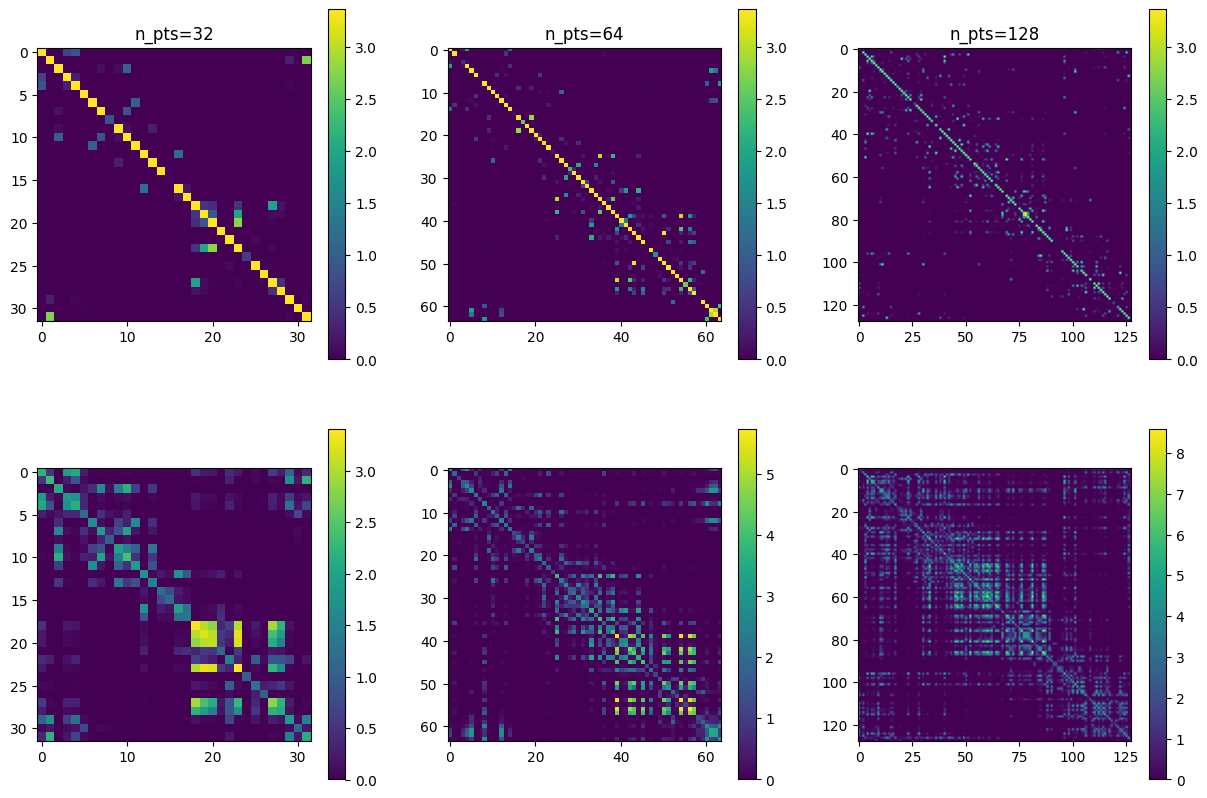

In [112]:
n_ptss = [32, 64, 128]

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i, n_pts in enumerate(n_ptss):
    landmarks = circle(n_pts)
    Q_half1 = evaluate_Q(landmarks, grid, alpha=1.0, sigma=0.1)
    Q_half2 = gaussian_Q_half_kernel(landmarks, alpha=1.0, sigma=0.3) + 1e-2 * jnp.eye(n_pts)
    Q1 = Q_half1 @ Q_half1.T
    Q2 = Q_half2 @ Q_half2.T
    im1 = ax[0, i].imshow(Q1)
    im2 = ax[1, i].imshow(Q2)
    # print(jnp.linalg.det(Q1))
    print(jnp.linalg.det(Q2))
    print(jnp.linalg.matrix_rank(Q2))
    # im = ax[i].imshow(jnp.linalg.inv(Q_half))
    # im = ax[i].imshow(jnp.linalg.pinv(Q_half))
    fig.colorbar(im1, ax=ax[0, i])
    fig.colorbar(im2, ax=ax[1, i])
    ax[0, i].set_title(f"n_pts={n_pts}")
plt.show()

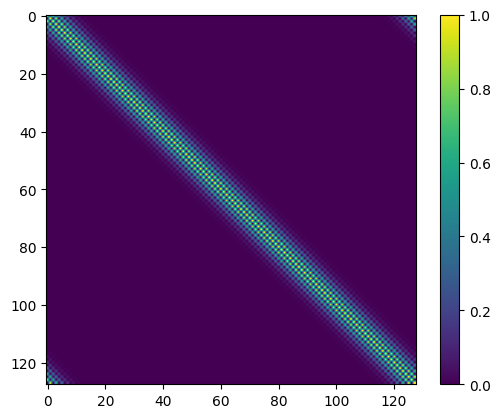

In [8]:
plt.imshow(Q_half)
plt.colorbar()

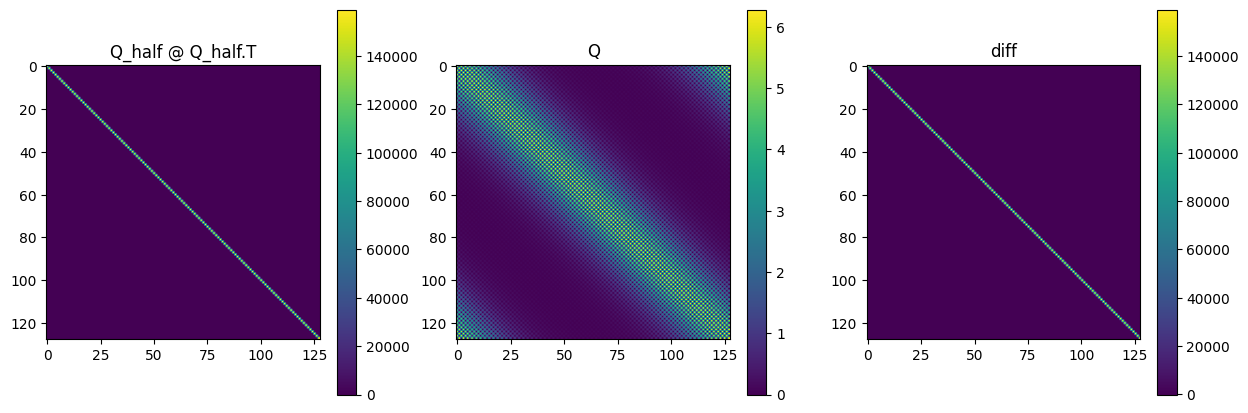

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
im1 = ax[0].imshow(Q_half @ Q_half.T)
ax[0].set_title("Q_half @ Q_half.T")
fig.colorbar(im1, ax=ax[0])
im2 = ax[1].imshow(Q)
ax[1].set_title("Q")
fig.colorbar(im2, ax=ax[1])
im3 = ax[2].imshow(Q_half @ Q_half.T - Q)
ax[2].set_title("diff")
fig.colorbar(im3, ax=ax[2])

In [84]:
def create_tridiagonal_matrix(n, a, b, c):
    # Main diagonal filled with 'a'
    main_diag = jnp.full((n,), a)
    
    # Superdiagonal and subdiagonal filled with 'b'
    off_diag1 = jnp.full((n-1,), b)
    off_diag2 = jnp.full((n-2,), c)
    
    # Create the tridiagonal matrix using `diag` for main and off-diagonals
    matrix = jnp.diag(main_diag) + jnp.diag(off_diag1, k=1) + jnp.diag(off_diag1, k=-1) + jnp.diag(off_diag2, k=2) + jnp.diag(off_diag2, k=-2)
    
    return matrix

# Example usage
n = 64  # Size of the matrix
a = 3  # Value for the main diagonal
b = 2  # Value for the off-diagonals
c = 1  # Value for the off-diagonals

matrix = create_tridiagonal_matrix(n, a, b, c)
print(jnp.linalg.det(matrix))

1452.0051
